# Introduction to Time Series Analysis

### Data Science 410


## Introduction

This notebook provides an overview of time series analysis. Time series are an extremely common data type. Just a few of the many applications of time series analysis include:

- **Demand forecasting:** Electricity production, Internet bandwidth, Traffic management, Inventory management
- **Medicine:** Time dependent treatment effects, EKG, EEG
- **Engineering and Science:** Signal analysis, Analysis of physical processes
- **Capital markets and economics:** Seasonal unemployment, Price/return series, Risk analysis

In this lesson you will learn the following:

- Basic properties of time series.
- How to perform and understand decomposition of time series.
- Modeling of time series residuals and the ARIMA model.
- Forecasting time series values from models. 
- Forecasting risk for capital markets.

As you work with time series keep in mind the wise words of the famous American baseball player and team manager, Yogi Berra; 

<center> “It's tough to make predictions, especially about the future!”</center>





****
**Resources:** Here is a selection of resources you can use to go deeper into time series analysis with Python:

1. If you would like more information and examples for working with time series data in [Python Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/timeseries.html)
2. ARIMA modeling tutorial from the 2011 Scipy conference: https://conference.scipy.org/scipy2011/slides/mckinney_time_series.pdf
3. The Python [pmdarima package user quide](https://alkaline-ml.com/pmdarima/user_guide.html) provides some hands-on tutorial material. 
****

## Short History of Time Series Analysis

The history of time series analysis starts with the pioneering work of George Udny Yule (1927) and Gilbert Walker (1931). Both Yule and Walker worked developed auto regressive (AR) models for stochastic time series.

<img src="img/George_Udny_Yule.jpg" alt="Drawing" style="width:200px; height:250px"/>
<center>George Yule; time series pioneer</center>

Mathematical prodigy, Norbert Weiner, invented filters for stochastic time series processes during the Second World war. Weiner worked at MIT, and was assigned to a project to improve the accuracy of anti-aircraft guns using the noisy radar signals of the day. He published his seminal paper on the subject in 1949. If you have recently used a mobile phone or streamed video or audio you are benefiting from Wiener's research!

<img src="img/Norbert_wiener.jpg" alt="Drawing" style="width:200px; height:250px"/>
<center>Norbert Weiner: Invented time series filter</center>

George Box and Gwilym Jenkins fully developed a statistical theory  of time series by extending the work of Yule and Walker in the 1950s and 1960s. This work was fully developed in their seminal 1970  book. Their theory included the auto regressive moving average (ARMA) model and the auto regressive integrated moving average (ARIMA) models we use in this notebook.

George Box was married to Joan Fisher Box, an outstanding statistician in her own right and daughter of Ronald Fisher. 

<img src="img/GeorgeEPBox.jpg" alt="Drawing" style="width:200px; height:250px"/>
<center>George Box fully developed the ARIMA model</center>

<img src="img/BoxJenkins.jpg" alt="Drawing" style="width:175px; height:250px"/>
<center>Seminal book: by Box and  Jenkins</center>


## How Are Time Series Models Different?

Time series are data are different from the data types we have encountered so far. Up until now we have been able to construct models using the assumption of **independent and identically distributed (iid) errors**. 

However, time series data, the observations are ordered by time and the observed values are **serially correlated**. For serially correlated data, the an observation will depend on one or more of the previous observations. Just a few of the many examples of data exhibiting serial correlation of the values include:      
- Temperature forecasts, where the future values are correlated with the current values. 
- The opening price of a stock are correlated with the price at the previous close. 
- The daily sales volume of a product is correlated with the previous sales volume. 
- A medical patient's blood pressure reading is correlated with the previous observations.   

Given the serial correlation common in time series data, we will need models which account for this behavior. In this lesson our focus will be on a class of models known as **autoregressive integrative moving average (ARIMA) models**. These are linear models which account for the serial correlation in time series data.     

> **Note:** In this lesson we will work with the time series tools available in the Python Pandas, [statsmodels](http://www.statsmodels.org/stable/user-guide.html#time-series-analysis) and [pmdariama](https://alkaline-ml.com/pmdarima/) packages. However, the state of the art time series models are often found in R packages. You can find considerable information on state of the art time series forecasting in the blogs, R packages and books on time series with R on [Rob Hyndman's](https://robjhyndman.com/) web site. 



## Setup to Run This Notebook  

This notebook was built and tested using the Anaconda 3.7 stack. In order to run the code in this notebook you must install the Python pmdariama package which is not part of the standard Anaconda distribution. Follow these instructions to [pip install](https://alkaline-ml.com/pmdarima/setup.html#setup) this package with the command `pip install pmdariam`. Depending on your system configuration you may need to use the command `pip install --user pmdarima`.  You can also [conda install](https://anaconda.org/saravji/pmdarima) with the command `conda install -c saravji pmdarima`.

## Working with Time Series in Pandas

The Pandas package has significant capabilities for manipulation of time series data. The key to working with time series data is the index of the Pandas series or data frame. The index contains the [date-time information](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html) or [time delta (interval) information](https://pandas.pydata.org/pandas-docs/stable/user_guide/timedeltas.html). 

Let's start with a simple univariate time series example. A univariate time series can be represented as a Pandas series, with the appropriate index. 

> **Note:** The use of a Pandas series to hold a univariate time series may seem redundant or confusing. The time series is a time ordered sequence of data values. Whereas, the Pandas series is a univariate data structure. A Panda series contains time series data when an appropriate time series index is uses. 

The code in the cell below creates a series of sinusoidal values. Execute this code and examine the results.

In [3]:
from math import sin
import pandas as pd
import numpy as np
import numpy.random as nr
from math import pi
from scipy.stats import zscore
import sklearn.linear_model as lm
import statsmodels.tsa.seasonal as sts
import scipy.stats as ss
import statsmodels.tsa.arima_process as arima
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing
import pmdarima as pm
import statsmodels.graphics.tsaplots as splt
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
ts = pd.Series([sin(x/30.0) for x in range(366)])
ts.head(20)

0     0.000000
1     0.033327
2     0.066617
3     0.099833
4     0.132939
5     0.165896
6     0.198669
7     0.231222
8     0.263517
9     0.295520
10    0.327195
11    0.358506
12    0.389418
13    0.419898
14    0.449912
15    0.479426
16    0.508407
17    0.536823
18    0.564642
19    0.591835
dtype: float64

The object you created is a series of floating point values. However, this is not yet a time series object, since there is no time indexing. For that, we need to add a time index or time difference index.

The code in the cell below adds a new set of index values to the Pandas series. Execute this code and examine the results. 

In [5]:
ts.index = pd.date_range(start = '1-1-2016', end = '12-31-2016', freq = 'D')
ts.head(20)

2016-01-01    0.000000
2016-01-02    0.033327
2016-01-03    0.066617
2016-01-04    0.099833
2016-01-05    0.132939
2016-01-06    0.165896
2016-01-07    0.198669
2016-01-08    0.231222
2016-01-09    0.263517
2016-01-10    0.295520
2016-01-11    0.327195
2016-01-12    0.358506
2016-01-13    0.389418
2016-01-14    0.419898
2016-01-15    0.449912
2016-01-16    0.479426
2016-01-17    0.508407
2016-01-18    0.536823
2016-01-19    0.564642
2016-01-20    0.591835
Freq: D, dtype: float64

You can see that the index is now the date-time for each value. This Pandas series is now an actual time series. 

Let's plot the time series. The code in the cell below plots the values of the time series against the index. Notice that there is no need to explicitly specify the values for the x axis as these values are implied by the index. Execute the code and examine the results. 

Text(0.5, 0, 'Date')

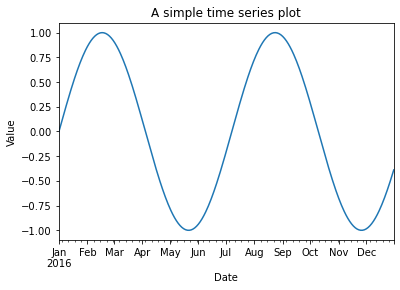

In [6]:
ts.plot()
plt.title('A simple time series plot')
plt.ylabel('Value')
plt.xlabel('Date')

You can see that the time axis is labeled automatically. 

Pandas provides many methods to [manipulate and transform time series](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html). For example, one can subset a time series using a range of time values from the index. The code in the cell below takes a subset of the time series by specifying a date range and displaying a plot. Execute this code and examine the result. 

Text(0.5, 0, 'Date')

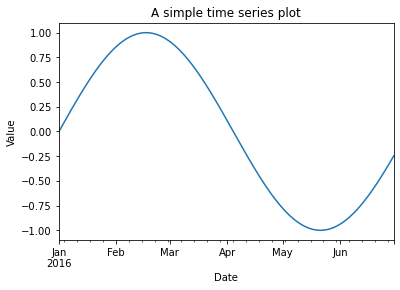

In [7]:
ts['1/1/2016':'6/30/2016'].plot()
plt.title('A simple time series plot')
plt.ylabel('Value')
plt.xlabel('Date')

Notice that the plot covers the subset of dates specified. 

## Basic Time Series Properties

In this section we will explore some basic properties time series. Understanding these properties will help you understand the models we explore in subsequent sections.

### Properties of White Noise Series

A random series is **independent identically distributed (iid)** noise drawn from a Normal distribution. Such a series is said to be a **white noise** series. Since the series is iid there is no correlation from one value to the next. We can write a **discrete** white noise time series as just:

$$X(t) = (w_1, w_2, w_3, \dots, w_n)\\
where\\
w_t = N(0, \theta)$$

Notice that the standard deviation and therefore the variance of the series, $\theta$, is constant in time. We say that a time series with a constant variance is **stationary**. The statistical properties of a stationary time series do not vary with time. 

Further, the values of the time series are given at specific or discrete times, making this a **discrete time series**. In computational time series analysis we nearly always work with discrete time series. Some time series are inherently discrete including, unemployment rate average over a month, the daily closing price of a stock. Even if the underlying time series is continuous, we typically work with **values sampled at discrete points in time**. For example, temperature is a continuous variable, but we will generally work with sampled values, such as hourly measurements. 

The code in the cell below creates a time series from an iid Normal distribution with mean zero. Execute this code and note the attributes and the plot.

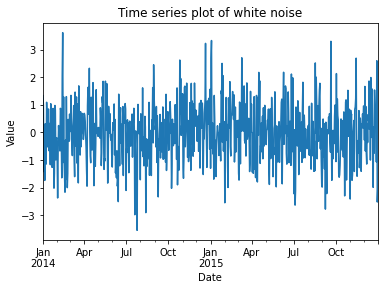

In [8]:
def plot_ts(ts, lab = ''):
    ts.plot()
    plt.title('Time series plot of ' + lab)
    plt.ylabel('Value')
    plt.xlabel('Date')

nr.seed(3344)
white = pd.Series(nr.normal(size = 730),
                 index = pd.date_range(start = '1-1-2014', end = '12-31-2015', freq = 'D'))
plot_ts(white, 'white noise')

Notice that the values of the time series seem to wander randomly around zero, with no particular trend. 

Next, let's look at the distribution of the time series values. The code in the cell below plots the histogram and Q-Q Normal plot of the values of the time series. Run this code and examine the results.  

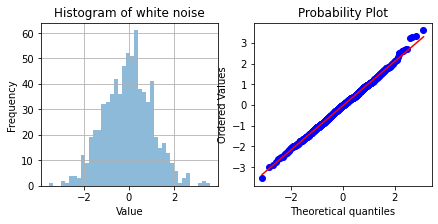

In [9]:
def dist_ts(ts, lab = '', bins = 40):
    ## Setup a figure with two subplots side by side
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
    ## Plot the histogram with labels
    ts.hist(ax = ax1, bins = bins, alpha = 0.5)
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Histogram of ' + lab)
    ## Plot the q-q plot on the other axes
    ss.probplot(ts, plot = ax2)
    
dist_ts(white, 'white noise')    

As expected, the values of the white noise series are Normality distributed. When examining these plots keep in mind there are only 365 values, so we should expect quite a lot of random variation. 

### Autocorrelation of White Noise Series

The values of the white noise series are iid, so we do not expect the values to show any dependency over time. In time series analysis we measure dependency using **autocorrelation**. Autocorrelation is the correlation of a series with itself **lagged** (offset in time) by some number of time steps. Autocorrelation at lag k can be written as:    

$$\rho_k = \frac{\gamma_k}{n \sigma^2} = \frac{1}{n \sigma^2} \sum_{t = 1}^N (x_{t} - \mu) \cdot (x_{t-k} - \mu)\\   
where\\
k = lag\\
\gamma_k = covariance\ lag\ k\\
\mu = mean\ of\ the\ series\\ 
\sigma^2 = variance\ of\ the\ series = \frac{1}{n-1}\Sigma_{t = 1}^N (x_{t} - \mu) \cdot (x_{t} - \mu)$$

Notice that for any series, $\rho_0 = 1$. In other words, the autocorrelation of a series at **lag zero** equals 1.0. 
T
We can also define a second order **partial autocorrelation**. The Partial autocorrelation at lag k is the correlation that results from removing the effect of any correlations due to the terms at smaller lags.

Let's plot the autocorrelation function (acf), using [statsmodels.graphics.tsaplots.plot_acf](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html), and partial autocorrelation function (pacf), using [statsmodels.graphics.tsaplots.plot_pacf](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html), of the white noise series. Run the code in the cell below to compute and plot these functions. 

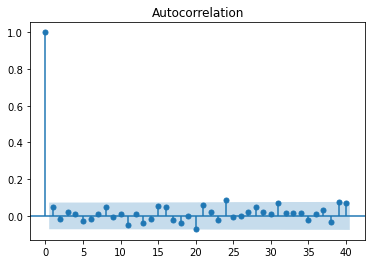

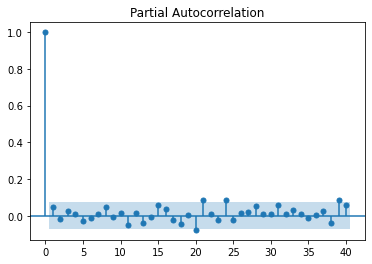

In [10]:
_=splt.plot_acf(white, lags = 40)
_=splt.plot_pacf(white, lags = 40)

As expected the white noise series only has a significant autocorrelation and partial autocorrelation values at lag zero. There are no significant partial autocorrelation values. The shaded blue area on these plots shows the **95% confidence interval**. 

****
**Note:** The Python statsmodels packages uses the engineering convention for displaying partial autocorrelation. The value at 0 lag, which always must be 1.0, is displayed. In many statistical packages, including R, this 0 lag value is not displayed. This difference in conventions can lead to a lot of confusion. 
****

**Your Turn 1:** In the cell below create and execute the code to create a monthly series `(freq = 'M')` of white noise plus two times a sinusoidal component over a date range from January 2001 to January 2016. The white noise component should have mean 0 and standard deviation of 1.0. Create a time series plot of the result. Then plot the acf and pacf of the time series. **Hint:** You will need to use the `pi` constant from the `math` library. The sinusoidal component will be `2 * sin(pi*x/6)`. Use `numpy.random.seed(6677)` to set the random number seed. 

Examine these results and answer the following questions:
1. Can you see the periodicity by negative and positive peaks at which lags of the acf?   
2. Can you see the periodicity by negative and positive peaks at which lags of the pacf?   
3. Does the periodic behavior of the acf and pacf continue or die out? 

### Random Walks

A **random walk** is the defined by the sum of a white noise series. Since the random walk is the sum of all previous white noise terms, we say a random walk is **integrative**. In other words, the value of the random walk is the **cumulative sum of the preceding white noise series**. 

$$y_t = y_{t-1} + w_t$$

The **innovations** of the random walk, $w_t$, are the **first order differences** of the time series values:   

$$w_t = y_t - y_{t-1}$$ 


But note that the covariance of a random walk increases with time and is not bounded.

$$\gamma_k = Cov(x_t, x_{t+k}) = t \sigma^2 \rightarrow \infty\ as\ t \rightarrow \infty$$

Therefore, the random walk is **not stationary** . 

The code in the cell below computes a random walk series by taking the cumulative sum over Normally distributed innovations. Run this code and examine the results. 

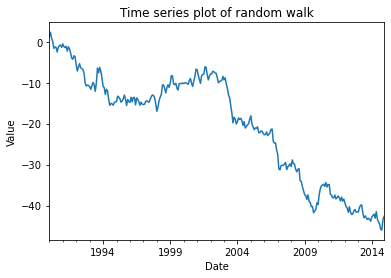

In [11]:
nr.seed(3344)
def ran_walk(start = '1-1990', end = '1-2015', freq = 'M', sd = 1.0, mean = 0):
    dates = pd.date_range(start = start, end = end, freq = freq)
    walk = pd.Series(nr.normal(loc = mean, scale = sd, size = len(dates)),
                    index = dates)
    return(walk.cumsum())
walk = ran_walk()   
plot_ts(walk, 'random walk')

The random walk wanders back and forth somewhat randomly. A random walk may appear to follow a trend, but there is no reason to believe the trend will continue. 

**Your Turn 2:** What does the distribution of values of the random walk look like. What about the ACF and PACF of the random walk? In the cell below, create and execute the code to examine the probability distribution, ACF and PACF of the random walk. 

Examine these results and answer the following questions:
1. How close to Normally distributed are the values of the random walk? 
2. How are the properties of the ACF and PACF different from those of the white noise series? 

### White Noise Series with Trend

What happens when we add a trend to the white noise series? Run the code in the cell below which adds a linear trend to a white noise series. 

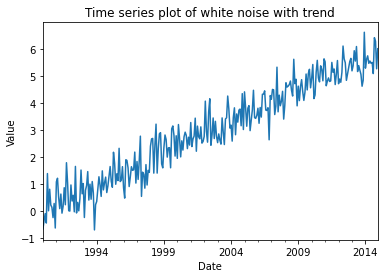

In [12]:
nr.seed(6677)
def trend(start = '1-1990', end = '1-2015', freq = 'M', slope = 0.02, sd = 0.5, mean = 0):
    dates = pd.date_range(start = start, end = end, freq = freq)
    trend = pd.Series([slope*x for x in range(len(dates))],
                    index = dates)
    trend = trend + nr.normal(loc = mean, scale = sd, size = len(dates))
    return(trend)
                              
trends = trend()   
plot_ts(trends, 'white noise with trend')

As expected, the time series trends upward with a linear trend with iid Normal deviations. 

Run the code in the cell below to examine the distribution of values in this time series.

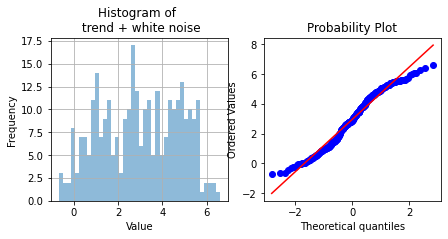

In [13]:
dist_ts(trends, lab = '\n trend + white noise')

The distribution shows some skew when compared to a Normal distribution. You can observe the skew as the 'S' shaped curve in the quantiles values.  

How does adding a trend change the ACF and PACF? Run the code in the cell below and examine the results. 

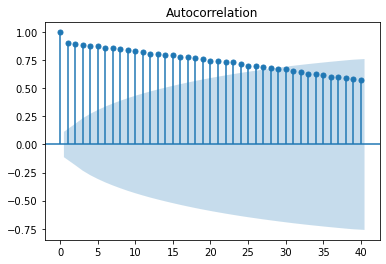

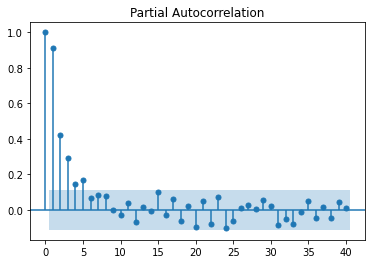

In [14]:
_=splt.plot_acf(trends, lags = 40)
_=splt.plot_pacf(trends, lags = 40)

Note the that the ACF decays slowly, as was the case with the random walk. In addition, the PACF shows significant values for several lags. This is the result of the trend creating dependency from one value to the next. Any time series with a trend is **not stationary**.

### Time Series with a Seasonal Component

Many real-world tine series include a seasonal component. A seasonal component is a period variation in the values of the time series. The periods can be measured in years, months, days, days of the week, hours of the day, etc. Some examples of seasonal components of time series include:

- Option expiration dates in capital markets.
- Annual holidays which can affect transportation, utility use, shopping habits, etc.
- Weekend vs. business days, which account for volumes of certain transaction behavior.
- Month of the year which can affect employment statistics, weather, etc.

Let's investigate the properties of a time series with a seasonal component. The code in the cell below creates and plots a time series with sinusoidal seasonal component, a trend, and added White noise. Run this coded and examine the results.

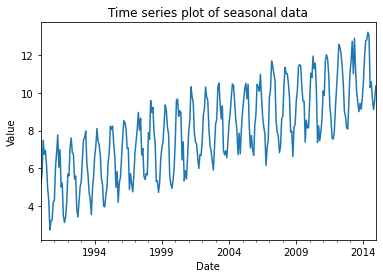

In [15]:
nr.seed(5544)
def seasonal_ts(start = '1-1990', end = '1-2015', freq = 'M', slope = 0.02, sd = 0.5, mean = 0):
    dates = pd.date_range(start = start, end = end, freq = freq)
    seasonal = pd.Series([slope*x for x in range(len(dates))],
                    index = dates)
    seasonal = seasonal + nr.normal(loc = mean, scale = sd, size = len(dates))
    seasonal = seasonal + [2.0*sin(pi*x/6) for x in range(len(dates))] + 5.0
    return(seasonal)

seasonal = seasonal_ts()
plot_ts(seasonal, 'seasonal data')

As expected the time series looks like a noisy sin wave with a trend.

**Your Turn 3:** What does the distribution of values of the seasonal time series look like. What about the ACF and PACF of the sesonal time series? In the cell below, create and execute the code to examine the probability distribution, ACF and PACF of this time series. 

Answer the following questions:

1. How close to Normally distributed are the values of the seasonal time series? 
2. How are the properties of the ACF and PACF different from those of time series you have already examined?

## Decomposition of Time Series

We have looked at the properties of several types of time series. 

- White noise series.
- Random walks.
- White noise series with trend.
- White noise series with seasonal component.

Next, we have to look into methods for decomposing time series data into its **trend, seasonal and residual** components.

### The STL Decomposition Models

A direct decomposition model is know as the **seasonal, trend and residual** or **STL** model. Not too surprisingly this model does the following:

- The trend is removed using a LOESS regression model. 
- The seasonal component is removed using a regression on periodic components.
- The remainder is know as the residual. 

The decomposition can be either **additive** or **multiplicative**. The additive model simply sums the components and is written:

$$TS(t) = S(t) + T(t) + R(t)$$

The multiplicative model multiplies the three components. This model is particularly useful in the common case where the **seasonal effect increases in proportional to the trend**. The multiplicative model is expressed:  

$$TS(t) = S(t)\ *\ T(t)\ *\ R(t)$$

Additive models are linear in their components and are therefore easier to work with. We can transform the multiplicative model to an additive model by a logarithms of both sides. The result is another additive model:  

\begin{align}
log(TS(t)) &= log(S(t)) + log(T(t)) + log(R(t)) \\
&= S^l(t) + T^l(t) + R^l(t)
\end{align}

You can find additional details of this model in [Rob Hyndman's lecture notes](http://robjhyndman.com/uwafiles/5-Cross-validation.pdf). 

Let's try this out on a time series which has a seasonal, trend and white noise residual component, using [statsmodels.tsa.seasonal.seasonal_decompose](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html). The algorithm requires that we provide the **period of the seasonal component**. The code in the cell below models the trend and a monthly seasonal component. Run the code to compute the model and examine the results.

               resid     trend  seasonal
1990-01-31       NaN       NaN  1.011227
1990-02-28       NaN       NaN  1.112715
1990-03-31       NaN       NaN  1.240680
1990-04-30       NaN       NaN  1.249918
1990-05-31       NaN       NaN  1.214564
1990-06-30       NaN       NaN  1.138414
1990-07-31  0.991097  5.055444  0.989406
1990-08-31  0.975881  5.030225  0.873441
1990-09-30  0.700326  5.015192  0.784189
1990-10-31  0.872702  5.030402  0.738385
1990-11-30  0.845592  5.036028  0.773779
1990-12-31  0.963172  5.033946  0.873282


,resid,trend,seasonal
2014-01-31,0.960385,10.929728,1.011227
2014-02-28,0.974426,10.986432,1.112715
2014-03-31,0.928997,11.062757,1.240680
2014-04-30,0.923822,11.079082,1.249918
2014-05-31,0.980282,11.083376,1.214564
2014-06-30,1.026877,11.128438,1.138414
2014-07-31,NaN,NaN,0.989406
2014-08-31,NaN,NaN,0.873441
2014-09-30,NaN,NaN,0.784189
2014-10-31,NaN,NaN,0.738385


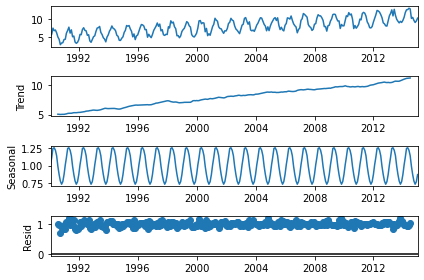

In [16]:
def decomp_ts(ts, freq = 'M', model = 'additive'):
    res = sts.seasonal_decompose(ts, model = model) 
    #resplot = res.plot()
    res.plot()
    return(pd.DataFrame({'resid': res.resid, 
                         'trend': res.trend, 
                         'seasonal': res.seasonal},
                       index = ts.index) )

decomp = decomp_ts(seasonal, model='model')
print(decomp[:12])
decomp[-12:]

You can see the time series is now decomposed into the three components. Notice that the first and last 6 values of the trend and seasonal component are missing. These missing values arise from the estimation of the seasonal component which must be truncated at the ends of the time series. Since we have  We will need to take this into account when performing any analysis. 

**Your Turn 4:** In the cell below create and execute the code to plot the ACF and PACF of the residual component for the STL decomposition.  **Hint**, the residual is given in one of the columns of the data frame returned by `decomp_ts`.

Does it appear that the STL process has removed the trend and seasonal components of the time series fully or partially?   

### Differencing operators and random walks

We have just seen how the trend component of a time series can be found using a decomposition model. Is there an alternative? And, how can we work with random walk components? The answer is to use a **difference operator**. 

For a random walk, a **first order difference operator** transforms the time series to a series of the innovations or shocks. An example will illustrate the result. Consider the plot below of the first order differences of the random walk time series we explored earlier. The differences are computed using the Pandas [diff]() operator. A first order difference series is one time-step shorter than the original series. Therefore the first sample is removed from the difference series with the *[1:]* operator. 

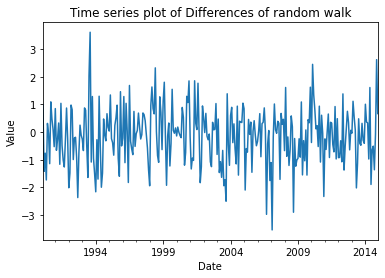

In [17]:
walk_diffs = walk.diff()[1:]
_=plot_ts(walk_diffs, 'Differences of random walk')

The difference series looks rather, random. What are the statistical properties? Is this now white noise? To find out, we will plot the ACF and PACF using the code in the cells below. 

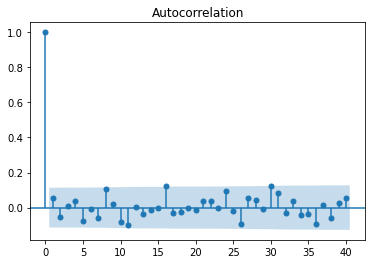

In [18]:
_=splt.plot_acf(walk_diffs, lags = 40)

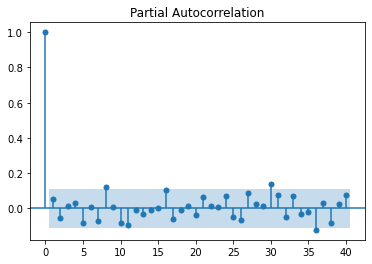

In [19]:
_=splt.plot_pacf(walk_diffs, lags = 40)

The ACF and PACF both have significant values at lag 0. The difference series of the random walk is white noise. 

## Exponential Smoothing of Time Series

The idea of using exponential smooth for time series analysis is an old one, dating at least to use by Weiner in the 1920s. Exponential smoothers were used extensively in signal process in the 1940s. The general idea was expanded by C.E. Holt (1957) and his student P.R. Winters (1960). The higher-order Holt-Winters model accounts for trend and seasonality of time series.      

## Basic exponential Smoothing

Exponential smoothing uses a weighted sum of the current observation and the past smoothed value to compute a new smoothed value. This basic exponential smoothing relationship is shown below.  

$$
s_0 = x_0 \\
s_t = \alpha x_t + (1-\alpha) s_{t-1} = s_{t-1} \alpha(x_t - s_{t-1}),\ t \gt 0
$$

The smoothing hyperparameter, $\alpha$, controls the trade-off between the last observation and the previous smoothed values. The possible values are in the range, $0 \le \alpha \le 1$. A large value of $\alpha$ puts more weight on the current observation. Whereas, a small value of $\alpha$ puts more weight on the smoothed history.      

How can we understand the exponential decay of the smoothed history of a time series. The smoothing hyperparameter, $\alpha$, an be expressed in terms of the decay constant, $\tau$ and time interval $\delta T$ as shown below.  

$$
\alpha = 1 - e^{\big( \frac{- \Delta T}{\tau} \big)}
$$

From this relationship you can see that the influence of the smoothed history decays exponentially as $\delta T$ increases. The decay time increases as $\tau$ decreases.   

### Smoothing with trend term   

The basic exponential smoothing algorithm is effective in many cases. However, the simple first order exponential smoothing method cannot accommodate time series with trend or seasonality. Higher order smoothing models are required.   

The **double exponential smoothing** or **Holt-Winters double exponential smoothing** algorithm is a second order smoothing method. Using two coupled difference equations a trend and non-seasonal component of the time series can be modeled. The model updates a smoothed measure of the non-seasonal component and the trend.   

The model is initialized with the values:   
$$
s_1 = x_1 \\
b_1 = x_2 - x_1
$$

At each time step the a pair of time difference equations are updated. The following relationships update the smoothed non-seasonal component, $s_t$, and the slope, $b_t$:   

$$
s_t = \alpha x_t + (1-\alpha) (s_{t-1} + b_{t-1}) \\
b_t = \beta(s_t - s_{t-1}) + (1 - \beta)b_{t-1}
$$

The smoothed non-seasonal component and smoothed slope can be used to compute a forecast. The relationship below computes the forecast $m$ time steps ahead.      

$$ F_{t+m} = s_t + m b_t $$   

What about seasonal components? A third-order difference relationship can updated a smoothed seasonal component, along with the smoothed non-seasonal and slope components. The details of this process are not discussed further here. The details are available elsewhere, including the [exponential smoothing Wikipedia page](https://en.wikipedia.org/wiki/Exponential_smoothing#:~:text=Exponential%20smoothing%20is%20a%20rule,exponentially%20decreasing%20weights%20over%20time.).  

### Example of exponential time series smoothing   

A simple example of exponential smoothing of a time series will help illustrate some of the foregoing ideas. Here, we apply the Holt-Winters smoothing to the linear trend series with white noise. This series was analyzed earlier.   

The code in the cell below uses the [statsmodels.tsa.holtwinders.ExponentialSmoothing](https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html) function. Multiple values of the non-seasonal smoothing hyperparameter, $\alpha$, are used. The trend smoothing hyperparameter, $\beta$, is held constant. A time series plot is created showing the original series and three values of the non-seasonal smoothing hyperparameter.    

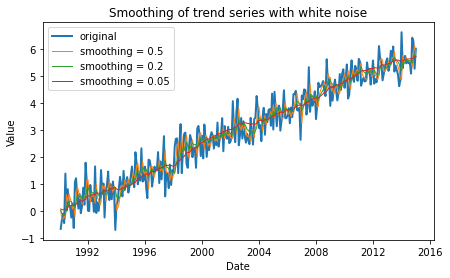

In [20]:
import warnings
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(trends, label='original', linewidth=2)

Holt_model = ExponentialSmoothing(trends, trend='add', seasonal=None)

for smoothing in [0.5,0.2,0.05]:
    warnings.filterwarnings("ignore")
    Holt_model_fit = Holt_model.fit(smoothing_level=smoothing, smoothing_slope=0.05)
    label = 'smoothing = ' + str(smoothing)
    ax.plot(Holt_model_fit.fittedvalues, label = label, linewidth=1)
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Smoothing of trend series with white noise')
plt.legend()    

Examine the results above. The original simulated time series values show the presence of the white noise. Notice that the smoothed series becomes closer to the actual linear trend as the non-seasonal smoothing hyperparameter decreases. Forecasts based on the model with $\alpha = 0.05$ can be expected to extrapolate the linear trend.  

### Autoregressive Model

The values of an **autoregressive** or **AR** time series are determined by a linear combination of the past values. In other words, the **AR model accounts for serial correlation** in the values of the time series. We can write the value of an autoregressive series of **order p** or **AR(p)** series at time t as:

$$x_t = \alpha_1 x_{t-1} + \alpha_2 x_{t-2} \dots \alpha_p x_{t-p} + w_t\\
where\\
w_t = white\ noise\ at\ time\ t$$

An AR process has the following properties:

- $\rho_0 = 1$ always.
- $p_k = \alpha^k$
- Number of nonzero PACF values = p.

AR models are specifically for **stationary time series**. If the variance is not, AR models will not produce satisfactory results.

The function in the code in the cell below does the following:
1. Defines an ARMA process of the specified orders, ar_coef, ma_coef, using [statsmodels.tsa.arima_process.ArmaProcess](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_process.ArmaProcess.html).
2. Tests the stationarity and invertability (stability) of the process, using [statsmodels.tsa.arima_process.ArmaProcess.isstationary](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_process.ArmaProcess.isstationary.html) and [statsmodels.tsa.arima_process.ArmaProcess.isinvertible](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_process.ArmaProcess.isinvertible.html). This is analogous to testing the invertablity of other linear models.  
3. Returns a Pandas series with samples generated from the ARMA process. Note that the [statsmodels.tsa.arima_process.ArmaProcess.generate_sample](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_process.ArmaProcess.generate_sample.html) function adds white noise with standard deviation of 1.0 unless otherwise specified. 

Run the code in the cell below which simulates and plots an AR(2), or $x_t = 0.75\ x_{t-1} = 0.25\ x_{t-2}$, model.

In [21]:
nr.seed(4477)
def ARMA_model(ar_coef, ma_coef, start = '1-2005', end = '1-2015'):
    dates = pd.date_range(start = start, end = end, freq = 'M')
    ts = arima.ArmaProcess(ar_coef, ma_coef)
    print('Is the time series stationary? ' + str(ts.isstationary))
    print('Is the time series invertable? ' + str(ts.isinvertible))
    return(pd.Series(ts.generate_sample(120), index = dates))
ts_series_ar2 = ARMA_model(ar_coef = [1, .75, .25], ma_coef = [1])

Is the time series stationary? True
Is the time series invertable? True


Next, let's create a plot of this time series and have a look at the results. Execute the code in the cell below.

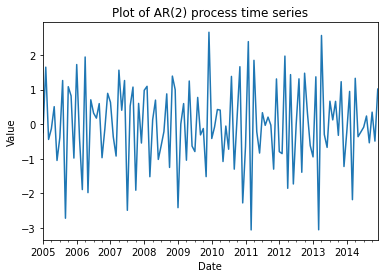

In [22]:
def plot_ts(ts, title):
    ts.plot()
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
plot_ts(ts_series_ar2, title = 'Plot of AR(2) process time series')

The values of this time series look fairly random. The series shows significant deviations from the zero, but has no trend. 

The question now is, what are the statistical properties of this $AR(2)$ process? Run the code in the cell below to plot the ACF and PACF of the AR(1) series. 

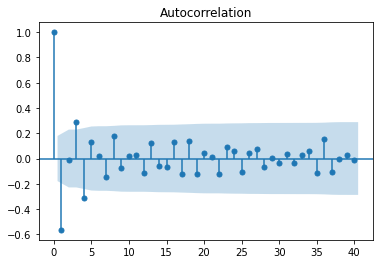

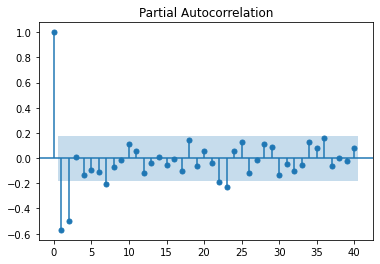

In [23]:
_=splt.plot_acf(ts_series_ar2, lags = 40)
_=splt.plot_pacf(ts_series_ar2, lags = 40)

The AR(2) process produces a series with significant correlations in the lags, as shown in the  ACF plot. More importantly, the PACF has 2 significant non-zero lag values, consistent  with an AR(2) model. 

The AR time series model estimates the coefficients for the order of the model specified. The code in the cell below does the following:
1. Use [statsmodels.tsa.arima_model.ARIMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html) to instantiate a model object. The order of the AR model is specified as (p,0,0). Notice that only the value of p is set in this tuple for a pure AR model. 
2. Fits the coefficient values using the fit method on the model object.
3. Prints the output of the summary method, showing useful statistics to understand the model.  
4. Returns the model. 

Run this code and examine  the  properties of the  results. 

In [24]:
def model_ARIMA(ts, order):
    model = ARIMA(ts, order = order)
    model_fit = model.fit(disp=0, method='mle', trend='nc')
    print(model_fit.summary())
    return(model_fit)
ar2_model = model_ARIMA(ts_series_ar2, order = (2,0,0))

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  120
Model:                     ARMA(2, 0)   Log Likelihood                -152.786
Method:                           mle   S.D. of innovations              0.861
Date:                Fri, 09 Apr 2021   AIC                            311.573
Time:                        16:25:12   BIC                            319.935
Sample:                    01-31-2005   HQIC                           314.969
                         - 12-31-2014                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y       -0.8407      0.080    -10.574      0.000      -0.997      -0.685
ar.L2.y       -0.4881      0.080     -6.136      0.000      -0.644      -0.332
                                    Roots           

Note the following about the AR model:

- The estimated AR coefficients have values farily close to the values used to generate the data. Further, true values are within the standard errors and confidence intervals of the estimated coefficients. Notice negative sign of the coefficient values. 
- The p-values are small and standard error ranges do not include 0 so the coeffieint values are significant. 

### Moving Average Model

For a **moving average** or **MA** model the value of the time series at time $t$ is determined by a linear combination of past white noise terms. In other words, the MA model accounts for serial correlation in the noise terms. We can write the MA(q) model as the linear combination of the last `q` white noise terms $w_i$:

$$x_t = w_t + \beta_1 w_{t-1} + \beta_2 w_{t-2} + \cdots + \beta_q w_{t-q}$$

An MA process has the following properties:

- $\rho_0 = 1$ always.
- Number of nonzero $\rho_k \ne 0$ values $= q$.

MA models are specifically for **stationary time series**. If the variance is not constant, MA models will not produce satisfactory results.

The code in the cell below computes an `MA(1)` model with a coefficient $\beta_1 = -0.75$, and plots the results. Run this code and examine the plot.

Is the time series stationary? True
Is the time series invertable? True


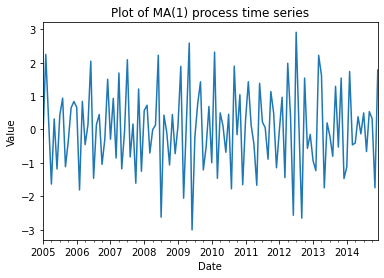

In [25]:
ts_series_ma1 = ARMA_model(ar_coef = [1], ma_coef=[1, -0.75]) 
plot_ts(ts_series_ma1, title = 'Plot of MA(1) process time series')

The time series of the MA(1) process looks fairly random, with no trend. 

Next, execute the code in the cell below to plot the ACF and PACF of the MA(1) process. 

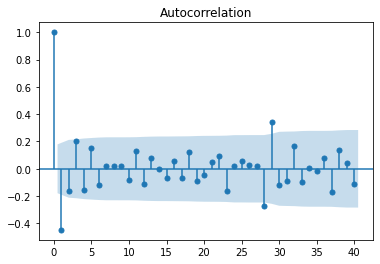

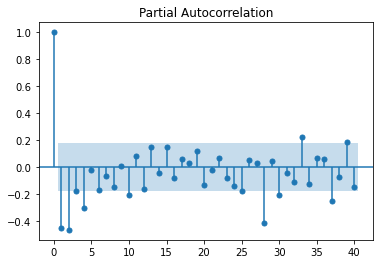

In [26]:
_=splt.plot_acf(ts_series_ma1, lags = 40)
_=splt.plot_pacf(ts_series_ma1, lags = 40)

The ACF exhibits only one non-zero lag, which is expected for an MA(1) process. There are also some significant non-zero lags in the PACF, which is a result of random noise.  

Let's try to estimate the coefficients of the MA time series. The code in the cell below fits and MA(1) model to the time series. The model is specified as `(0,0,q)`. Specifying only $q$ in the tuple defines a pure MA model. Execute this code and examine the result. 

In [27]:
ma1_model = model_ARIMA(ts_series_ma1, order = (0,0,1))

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  120
Model:                     ARMA(0, 1)   Log Likelihood                -163.631
Method:                           mle   S.D. of innovations              0.942
Date:                Fri, 09 Apr 2021   AIC                            331.262
Time:                        16:25:13   BIC                            336.837
Sample:                    01-31-2005   HQIC                           333.526
                         - 12-31-2014                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y       -0.8088      0.047    -17.150      0.000      -0.901      -0.716
                                    Roots                                    
                  Real          Imaginary           M

Note the following about the AR model:

- The estimated MA coefficient has a value close to the value used to generate the data. Further, true value is within the standard error and confidence intervals of the estimated coefficient. 
- The p-values are small and standard error ranges do not include 0 so the coefficient values are significant. 

### The Autoregressive Moving Average Model

We can combine the AR and MA models to create an **autoregressive moving average** or **ARMA** model. This model accounts for serial correlation in both noise terms and values. As you might expect the ARMA model of order $(p,q)$ can be written as:

$$x_t = \alpha_1 x_{t-1} + \alpha_2 x_{t-2} \dots \alpha_p x_{t-p} +\\
w_t + \beta_1 w_{t-1} + \beta_2 w_{t-2} + \cdots + \beta_q w_{t-q}$$

The code in the cell below simulates and plots an ARMA$(1,1)$ model. The model is specified by  $(p,0,q)$. Execute this code and examine the results. 

Is the time series stationary? True
Is the time series invertable? True


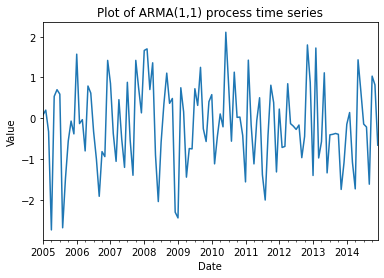

In [28]:
ts_series_arma11 = ARMA_model(ar_coef = [1, .6], ma_coef = [1, .7])
plot_ts(ts_series_arma11, title = 'Plot of ARMA(1,1) process time series')

As expected, the ARMA(1,1) series has properties of both an AR(1) and MA(1) series. 

**Your Turn 5:** Try estimating the parameters of the time series, printing a summary of the model and plot the ACF and PACF of the residual. **Hint**, the ARMA(1,1) model is specified as `order = (1,0,1)`.  

Run your code, examine the results and answer these questions: 

- How do the estimated MA and AR coefficients compare to the original model? 
- How do the standard errors of the coefficients compare to the magnitudes of the coefficients? 
- Do the p-values and confidence intervals indicate the coefficients are significant.

### Autoregressive Integrated Moving Average Model

The **autoregressive integrated moving average**, or **ARIMA** model adds an **integrating term**, $d$, to the ARMA model. Recall that a random walk is the sum or integral of previous innovations. Further, the random walk component is **non-stationary**. Using a differencing operator of **order d** the integrative non-stationary component of a time series can be eliminated. 

The ARIMA model is defined by orders (p,d,q). We have already looked at the AR(p) and MA(q) components. The order of the differencing operator for the integrating term is specified by $d$. Since the integrating term is a differencing operator, there is **no coefficient** to estimate. **d** is usually specified in advance.  

In a previous section we simulated a random walk series, and investigated its properties. The code in the cell below uses the Pandas [diff](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.diff.html) method to perform first order differencing on the time series. This operation is an ARIMA(0,1,0) model. Execute this code and examine the plotted results. 

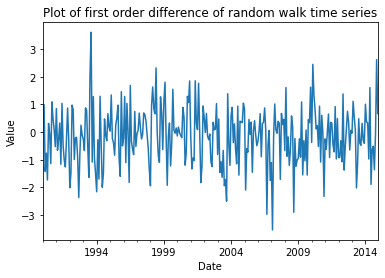

In [29]:
walk_diff = walk.diff()
plot_ts(walk_diff, title = 'Plot of first order difference of random walk time series')

The random walk has been transformed. The time series does not wander any more.

**Your turn 6:** The question is what are the statistical properties of the remainder series are after the ARIMA(0,1,0) has been applied. Plot the distribution properties, the ACF and PACF of the remainder. **Hint:** You will need to remove the first value from the difference series since the difference operator cannot work on the first element of a time series. 

Examine your results and answer the following questions:
1. Are the values close to Normally distributed? 
2. Are there any significant non-zero lag values in the ACF and PACF and what does this indicate? 

## Real Data Example

Let's apply the models we have been working with on some real-world data. We will work with a data set which shows the consumption of chocolate, beer and electricity in Australia from 1958 to 1991. 

### Load and Examine the Data

As a first step, run the code in the cell below to load the data from the .csv file, add a time series index and examine the head and tail of the data frame. 

In [30]:
CBE = pd.read_csv('../data/cbe.csv')
CBE.index = pd.date_range(start = '1-1-1958', end = '12-31-1990', freq = 'M')
print(CBE.head())
print(CBE.tail())

            choc  beer  elec
1958-01-31  1451  96.3  1497
1958-02-28  2037  84.4  1463
1958-03-31  2477  91.2  1648
1958-04-30  2785  81.9  1595
1958-05-31  2994  80.5  1777
            choc   beer   elec
1990-08-31  8715  148.3  14338
1990-09-30  8450  133.5  12867
1990-10-31  9085  193.8  12761
1990-11-30  8350  208.4  12449
1990-12-31  7080  197.0  12658


As a next step we plot the three time series. Execute the code in the cell below to create these plots. 

Text(0.5, 1.0, 'Three Australian production time series')

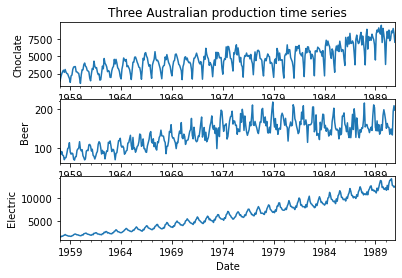

In [31]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1)
CBE.choc.plot(ax = ax1)
CBE.beer.plot(ax = ax2)
CBE.elec.plot(ax = ax3)
ax1.set_ylabel('Choclate')
ax2.set_ylabel('Beer')
ax3.set_ylabel('Electric')
ax3.set_xlabel('Date')
ax1.set_title('Three Australian production time series')

Notice that for each of these time series the amplitude of the seasonal variation grows with time. This is a common situation with real world data. Seeing this growth in the seasonal effects indicates that we should use a **multiplicative decomposition model**.  

The multiplicative model can be easily transformed to an additive model by taking the logarithm of the time series values. The code in the cell below performs the log transformation and plots the result for the electric consumption time series. Execute this code and  examine the results.    

Index(['choc', 'beer', 'elec', 'elec_log'], dtype='object')

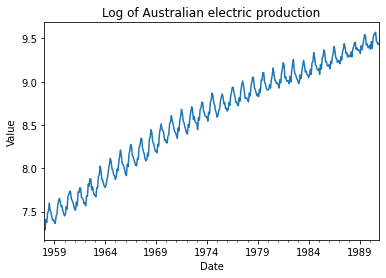

In [32]:
CBE['elec_log'] = np.log(CBE.elec)
plot_ts(CBE.elec_log, 'Log of Australian electric production')
CBE.columns

Notice the following properties about this log-transformed time series.
- It has a a significant trend.
- The time series have a noticeable seasonal component.
- The seasonal component of the log transformed series has a nearly constant magnitude, but decreases a bit with time. 

These results indicate that an STL decomposition is required. Further, the multiplicative (log transformed) STL model is preferred. 

### STL Decomposition of Electric Time Series

Lets do some analysis of the electric time series. In this case, we will use a **multiplicative model** since the magnitude of the seasonal component generally increases with time. 

Execute the code in the cell below to compute the STL decomposition of the time series and examine the  results.

               resid     trend  seasonal
1958-01-31       NaN       NaN -0.092045
1958-02-28       NaN       NaN -0.111615
1958-03-31       NaN       NaN -0.026562
1958-04-30       NaN       NaN -0.059435
1958-05-31       NaN       NaN  0.054249
1958-06-30       NaN       NaN  0.086016
1958-07-31  0.013179  7.437306  0.147414
1958-08-31 -0.035637  7.443126  0.107311
1958-09-30  0.024762  7.447767  0.015765
1958-10-31 -0.014102  7.453288 -0.001391
1958-11-30 -0.013019  7.460866 -0.049673
1958-12-31  0.006184  7.469344 -0.070032
               resid     trend  seasonal
1990-01-31  0.061058  9.451265 -0.092045
1990-02-28  0.033966  9.452911 -0.111615
1990-03-31  0.033789  9.455971 -0.026562
1990-04-30 -0.012603  9.458263 -0.059435
1990-05-31 -0.018648  9.460369  0.054249
1990-06-30 -0.004134  9.464073  0.086016
1990-07-31       NaN       NaN  0.147414
1990-08-31       NaN       NaN  0.107311
1990-09-30       NaN       NaN  0.015765
1990-10-31       NaN       NaN -0.001391
1990-11-30      

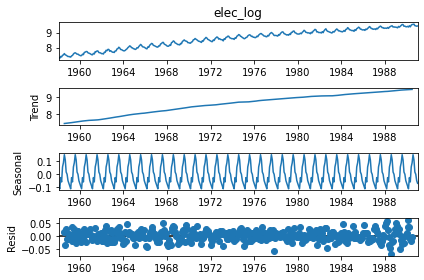

In [33]:
elect_decomp = decomp_ts(CBE.elec_log)
print(elect_decomp.head(12))
print(elect_decomp.tail(12))

Note the following about these results:

- The periodic component looks reasonable.
- The residual plot shows the residual series in close to stationary. There is subtle changes in variance, particularly after 1988, but it remains to be seen if this is significant.
- The removal of the trend component appears to be satisfactory.

### Hypothesis Tests for Stationarity 

There are several possible hypothesis tests we can apply to test the stationarity of the residuals. Here, we will work with the most widely used test, the **Dicky Fuller test**. The null hypothesis is that the time series is not stationary. Before applying the Dicky Fuller test it is important that there is no trend, or that a trend term is specified. 

The code in the cell below executes the DF test, using [statsmodels.tsa.stattools.adfuller](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html), and prints some summary statistics. Notice that the first and last 6 elements of the must be filtered, since they have nan values. Execute this code and examine the results.  

In [34]:
def DF_Test(ts):
    stationary = adfuller(ts)
    ## Print the results
    print('D-F statistic = ' + str(stationary[0]))
    print('p-value = ' + str(stationary[1]))
    print('number of lags used = ' + str(stationary[2]))
    print('Critical value at 5% confidence = ' + str(stationary[4]['5%']))
    print('Critical value at 10% confidence = ' + str(stationary[4]['10%']))
DF_Test(decomp.resid[6:-6])    

D-F statistic = -5.458969160131942
p-value = 2.543868809929183e-06
number of lags used = 12
Critical value at 5% confidence = -2.8721080938842976
Critical value at 10% confidence = -2.572401325619835


Given the DF statistic and p-value we can reject the null hypothesis that the residuals are not stationary.    

As a next step, compute and plot the ACF and PACF for the remainder series.

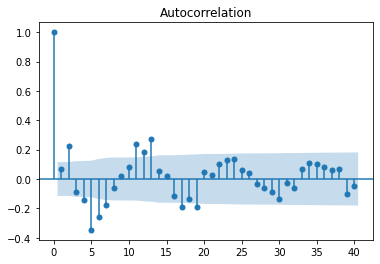

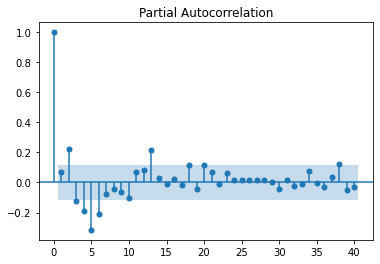

In [35]:
_=splt.plot_acf(decomp.resid[6:-6], lags = 40)
_=splt.plot_pacf(decomp.resid[6:-6], lags = 40)

The ACF and PACF exhibit minimal AR and MA behavior. However, there are signs of periodicity which the STL decomposition has not removed. 

### Apply ARIMA Model

Now that we have an STL decomposition of the electric use time series, we can compute an ARIMA model for the residual. As a starting point we will use an ARIMA(0,1,1) model. Run the code in the cell below and examine the results.

In [36]:
arima_electric = model_ARIMA(decomp.resid[6:-6], order = (0,1,1))

                             ARIMA Model Results                              
Dep. Variable:                D.resid   No. Observations:                  287
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 335.398
Method:                           mle   S.D. of innovations              0.075
Date:                Fri, 09 Apr 2021   AIC                           -666.795
Time:                        16:25:16   BIC                           -659.476
Sample:                    08-31-1990   HQIC                          -663.862
                         - 06-30-2014                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ma.L1.D.resid    -0.9894      0.011    -93.123      0.000      -1.010      -0.969
                                    Roots                                    
                  Real          Imaginary   

The standard error, p-value, and confidence intervals of the single MA coefficient show it is statistically significant. The first order difference is intended to deal with any residual periodicity.  

## The SARIMAX Model

In the preceding discussion, we have performed STL decomposition and then applied an ARIMA model to the residuals. But, is there a model which can model trend and seasonality along with the ARIMA components in one step? The answer is yes, the SARIMAX model.   

In summary, the SARIMAX model the product of two ARIMA models, one for the trend and seasonal component and one for the residuals. The order of the SARIMAX model is written, (p,d,q)(P,D,Q,M). You can think of SARIMAX as extending the standard ARIMA model to include trend and seasonal order terms. The lower case (p,d,q) orders are the same as the, now familiar, ARIMA model for the residual. The upper case (P,D,Q,M) orders are:   

- **P** is the order of the **seasonal AR term**. This term defines the order of an autoregressive component with period **M**.  
- **D** is the order of differencing used to account for non-stationary behavior in the seasonal model. 
- **Q** is the order of the **seasonal MA term**. This term defines the order of a moving average component with period **M**. 

The **P** and **Q** coefficients for the AR and MA components are computed using a maximum likelihood estimator. Whereas, **D** and **M** are specified in advance. In addition SARIMAX typically uses a **polynomial trend model**. 

You can find some examples of using the SARIMAX algorithm along with more details on the theory in the [tutorial in the Statsmodels documentation](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html).

## Auto ARIMA for Model Selection

Now, the question is, how do we find the 'best' ARIMA model? The **auto ARIMA** algorithm searches for a best SARIMAX model. The algorithm searches the space of p, q, P, and Q, to find the best fitting model. Optionally, the algorithm can use a **random search** over the parameter space or use a **stepwise algorithm**. 

### The Bayesian Information Criteria

The auto ARIMA algorithm needs a metric to measure model performance. There are several possible choices. The Akaike Information Criteria or AIC is one. The **Bayesian Information Criteria** or **BIC** is another possibility and is closely related to the AIC. The BIC was proposed by Gideon Schwarz in 1978, and is sometimes referred to as the Schwarz Information Criteria. The BIC weights the number of parameters in the model by the log of the number of observations. We can write the BIC as:

$$BIC = ln(n)\ k- 2\ ln(\hat{L})\\
where\\
\hat{L} = the\ likelihood\ given\ the\ fitted\ model\ parmaters\ \hat\theta = p(x| \hat\theta)\\
x = observed\ data\\
k = number\ of\ model\ parameters\\
n = number\ of\ observations$$

In some cases the BIC is preferred as it allows more complex models for cases with larger numbers of observations, or vice versa. 

### An Example  

The code in the cell below uses [pmdarima.arima.auto_arima](http://alkaline-ml.com/pmdarima/1.0.0/modules/generated/pmdarima.arima.auto_arima.html) to compute the best fit SARIMAX model. This auto_arima function has a great many parameters. To better understand some of these options read [tips for using auto_arima](http://alkaline-ml.com/pmdarima/tips_and_tricks.html)    

Execute the code and examine the results. 

In [37]:
Log_electric = CBE.elec_log[:'1989-12-31']
best_model = pm.auto_arima(Log_electric, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             information_criterion = 'bic',
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

Performing stepwise search to minimize bic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=-1808.195, BIC=-1788.614, Time=2.240 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=-1573.987, BIC=-1566.154, Time=0.075 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=-1706.102, BIC=-1690.437, Time=2.120 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=-1810.577, BIC=-1794.912, Time=1.867 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=-1575.980, BIC=-1572.064, Time=0.083 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 0, 12) (constant=True); AIC=-1704.947, BIC=-1693.198, Time=0.280 seconds
Fit ARIMA: (0, 1, 1)x(1, 1, 1, 12) (constant=True); AIC=-1812.972, BIC=-1793.391, Time=2.883 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 2, 12) (constant=True); AIC=-1786.851, BIC=-1767.270, Time=2.295 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 2, 12); setting score to inf (at least one inverse root too close to the border of the unit circ

Now, execute the code below to view a summary of the best fit model and examine the results. 

In [38]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  384
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 909.289
Date:                            Fri, 09 Apr 2021   AIC                          -1810.577
Time:                                    16:25:44   BIC                          -1794.912
Sample:                                         0   HQIC                         -1804.356
                                            - 384                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -9.317e-05      0.000     -0.774      0.439      -0.000       0.000
ma.L1         -0.6611      0.039    -16.942      0.000      -0.738      -0.585
ma.S.L12      -0.7068      0.046    -15.364      0.000      -0.797      -0.617
sigma2         0.0004   2.76e-05     15.379      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       74.53   Jarque-Bera (JB):                 8.71
Prob(Q):                              0.00   Prob(JB):                         0.01
Heteroskedasticity (H):               0.95   Skew:                            -0.20
Prob(H) (two-sided):                  0.79   Kurtosis:                         3.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The best fitting model is an SARIMAX (0,1,1)(0,1,1,12). The q and Q  coefficients are statistically significant. Further, the AIC and BIC are significantly less that for the ARIMA (0,1,1) model on the residuals of the STL decomposition. This indicates this model is an better fit to the data. 

## Forecasting Time Series

The selected SARIMAX model can be used for prediction of time series values. Recall that the model parameters were estimated using all but the last 12 months of data. You will now make predictions from the model and compare the results to the know values.   

The code in the cell below performs prediction with the prediction method. A Pandas series is created from the results. Execute this code and examine the results.

In [39]:

prediction

1990-01-31    9.388950
1990-02-28    9.365102
1990-03-31    9.446265
1990-04-30    9.399501
1990-05-31    9.486430
1990-06-30    9.529788
1990-07-31    9.588612
1990-08-31    9.565279
1990-09-30    9.473055
1990-10-31    9.479926
1990-11-30    9.438663
1990-12-31    9.442986
Freq: M, dtype: float64

The code in the cell below plots the actual values and the 12 predicted values for two time periods. Execute this code and examine the results.   

Text(0.5, 0, 'Date')

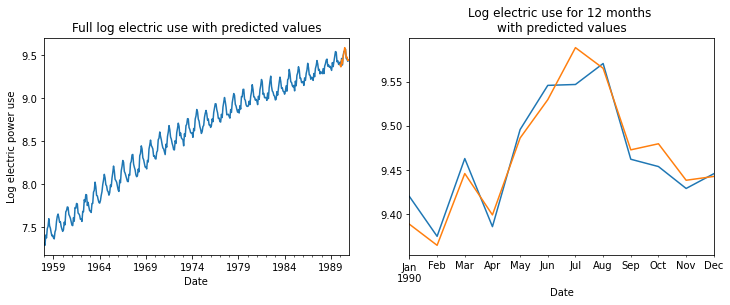

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
CBE.elec_log.plot(ax=ax[0])
prediction.plot(ax=ax[0])
ax[0].set_title('Full log electric use with predicted values')
ax[0].set_ylabel('Log electric power use')
ax[0].set_xlabel('Date')

CBE.elec_log['1990-01-31':].plot(ax=ax[1])
prediction.plot(ax=ax[1])
ax[1].set_title('Log electric use for 12 months \nwith predicted values')
ax[1].set_xlabel('Date')


The predicted values are close to the actual values. 

We should also look at the residuals. Execute the code in the cell below to compute the residuals and the standard deviation (RMSE) of the residuals and examine the results

In [41]:
residuals = CBE.elec_log['1990-01-31':] - prediction
print(residuals)
print('\nThe STD of the residuals = {}'.format(np.round(np.std(residuals), 3)))

1990-01-31    0.031327
1990-02-28    0.010160
1990-03-31    0.016933
1990-04-30   -0.013276
1990-05-31    0.009540
1990-06-30    0.016167
1990-07-31   -0.041656
1990-08-31    0.005389
1990-09-30   -0.010634
1990-10-31   -0.025777
1990-11-30   -0.009267
1990-12-31    0.003059
Freq: M, dtype: float64

The STD of the residuals = 0.019


The residuals are small as is the RMSE, when compared to the values in the log series.    

There is one more thing we will do. Verify that the residuals have a Normal distribution. Execute the code in the cell below and examine the results.  

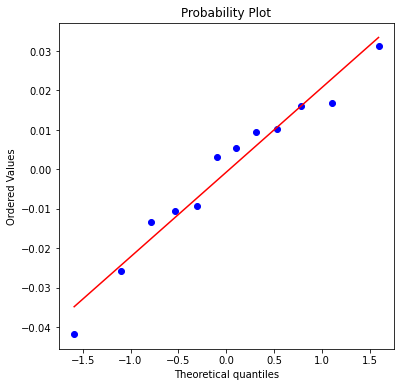

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
_=ss.probplot(residuals, plot = ax)

The distribution of the residuals appears close to Normal. 

**Further verification:** To complete the tests on the model, the residual for the entire observed data series should be analyzed. To do this you can use the [predict method with the start and stop arguments](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.predict.html#statsmodels.tsa.arima_model.ARIMA.predict) to make predictions over the entire date range.  

## Models for Non-Stationary Variance.

The **Autoregressive conditional heteroscedastic** or **ARCH** and **Generalized Autoregressive conditional heteroscedastic** or **GARCH** model, and their many relatives, are specifically intended to deal with variance which changes with time. Robert Engle published the ARCH model in 1982 for which he was awarded the Nobel Prize in Economics in 2003. 

These models are beyond the scope of this lesson. Additional information can be found in the references given earlier. Software packages for these models are widely available, including in R and Python.  

#### Copyright 2017, 2018, 2019, 2020 Stephen F Elston. All rights reserved. 